# Analyse qualitative / exploratoire des motifs

## 1. Chargement du dataset
- Import du fichier `passwords_processed.csv`
- Aperçu initial (head)


- Fréquences de caractères et de classes de caractères
- Substrings / patterns récurrents
- Séquences de chiffres, dates ou motifs particuliers
- Analyse de répétitions ou de similarités

Analyse qualitative / exploratoire des mots de passe
1. Objectif

L’objectif est d’explorer le contenu textuel des mots de passe pour détecter des motifs, des tendances ou des régularités que les statistiques numériques seules ne révèlent pas.

On s’intéresse notamment à :

La composition des caractères

Les patterns récurrents (substrings fréquentes, séquences)

Les séquences numériques ou dates

Les répétitions et similarités entre mots de passe

2. Fréquences de caractères et de classes de caractères

But : comprendre quels caractères sont utilisés et dans quelle proportion.

On peut compter chaque caractère dans l’ensemble des mots de passe.

On peut aussi regrouper par classes : lettres minuscules, lettres majuscules, chiffres, caractères spéciaux.

Exemple d’indicateurs :

Pourcentage de mots de passe contenant au moins un chiffre, une majuscule, un caractère spécial

Fréquence moyenne d’apparition d’une lettre ou d’un chiffre

Histogrammes ou barplots par classe de caractères

Intérêt : cela révèle des habitudes humaines ou des contraintes implicites dans les mots de passe faibles vs forts.

3. Substrings / patterns récurrents

But : identifier des motifs qui reviennent souvent dans les mots de passe.

Exemples de substrings fréquentes : "123", "abc", "password", "!" répétitifs.

Méthodes possibles :

Découper chaque mot de passe en n-grams (séquences de n caractères) et compter les occurrences

Rechercher des substrings fréquentes sur tous les mots de passe

Intérêt : ces motifs peuvent servir pour améliorer les règles de sécurité ou entraîner des modèles de génération/évaluation de mots de passe.

4. Séquences numériques, dates ou motifs particuliers

But : repérer les séquences faciles à deviner.

Séquences numériques simples : "12345", "2023"

Dates : "01011990", "31-12-99"

Répétitions : "aaaa", "1111"

Méthodes :

Utiliser des regex pour détecter des séquences consécutives de chiffres

Détecter des motifs de type date (\d{4}, \d{2}-\d{2}-\d{4})

Compter les répétitions ou caractères identiques consécutifs

Intérêt : ces mots de passe sont considérés faibles même si leur longueur ou diversité semble correcte.

5. Analyse de répétitions et similarités

But : mesurer la ressemblance entre mots de passe.

Détecter les mots de passe identiques ou très similaires (passw0rd vs password)

Méthodes : distance de Levenshtein, clustering par similarité, hash + comptage

Intérêt : cela permet de détecter des patterns humains et d’estimer la robustesse relative des mots de passe.

6. Visualisations et outils

Pour chaque type d’analyse :

Barplots / histogrammes pour les fréquences

Wordclouds pour les substrings fréquentes

Heatmaps ou scatterplots pour les séquences ou similarités

Tableaux pour les motifs ou n-grams les plus fréquents

Si tu veux, je peux te faire directement le squelette complet du notebook en Markdown + cellules Python, prêt à être rempli avec ton dataset, pour que tu puisses le lancer et visualiser tout ça.

Le modèle doit apprendre que :

Pomme1!
Équinoxe2024!
Password123!
Qwerty2022?


ne sont pas des mots de passe forts
même s’ils ont :

une longueur excellente

une diversité bonne

une entropie quasi parfaite

Ton modèle doit être capable de pénaliser :

les dates

les mots du dictionnaire

les patterns humains

les séquences

les prénoms, noms propres

les motifs clavier

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# Configuration du style des graphiques
sns.set_theme(style="whitegrid")
print("Imports terminés avec succès.")

Imports terminés avec succès.


In [24]:
import pandas as pd

# 1. Chargement des Mots de Passe
df = pd.read_csv("../processed/passwords_processed.csv")

# 2. Chargement du Dictionnaire Linguistique
corpus = pd.read_csv("../Dictionnaries/processed/linguistic_dictionary.csv")

# --- CORRECTION ICI : NETTOYAGE FORCÉ ---
# On s'assure que tout est en string, minuscule, et SANS ESPACES invisibles
corpus['token'] = corpus['token'].astype(str).str.lower().str.strip()

# 3. Création des sets optimisés
words_set = set(corpus[corpus['category'] == 'word']['token'])
names_set = set(corpus[corpus['category'] == 'name']['token'])
places_set = set(corpus[corpus['category'] == 'place']['token'])
weak_set = set(corpus[corpus['category'] == 'weak_pwd']['token'])

print(f"Dataset chargé : {len(df)} mots de passe")
print(f"Dictionnaire chargé : {len(corpus)} tokens")

# --- PETIT DIAGNOSTIC IMMÉDIAT ---
# On regarde à quoi ressemblent vraiment les données maintenant
print("Exemple de 5 mots du set 'words_set' :", list(words_set)[:5])
print(f"Test immédiat : 'thomas' est dans names_set ? {'thomas' in names_set}")

Dataset chargé : 99992 mots de passe
Dictionnaire chargé : 251083 tokens
Exemple de 5 mots du set 'words_set' : ['aboveboard', 'restructure', 'pleated', 'bristling', 'gizzard']
Test immédiat : 'thomas' est dans names_set ? True


Calcul de la composition en cours...


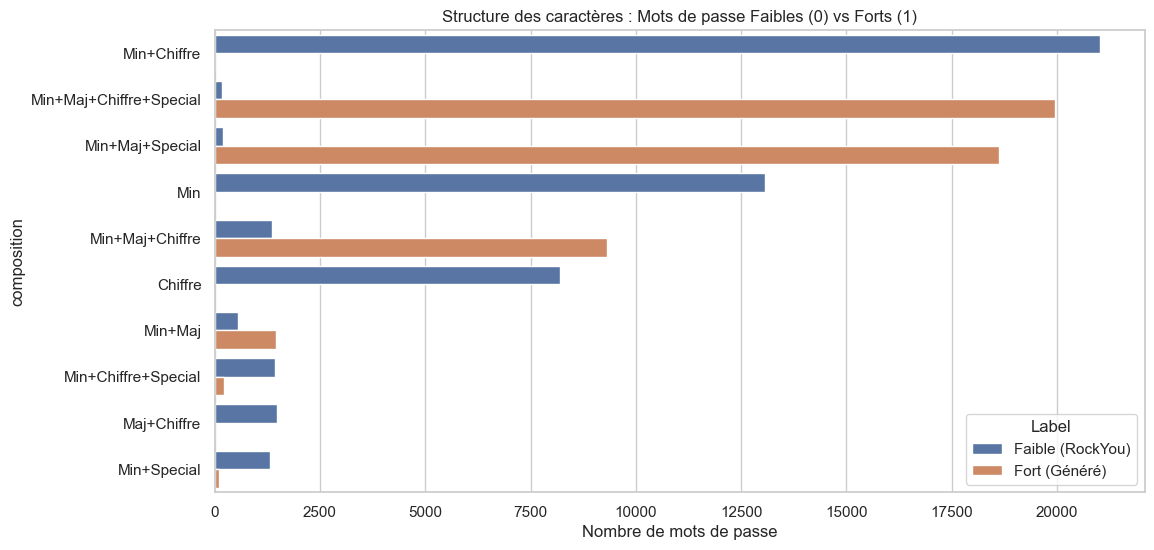

In [25]:
# Fonction pour décrire de quoi est fait le mot de passe
def get_composition_type(pwd):
    pwd = str(pwd)
    types = []
    if any(c.islower() for c in pwd): types.append('Min')
    if any(c.isupper() for c in pwd): types.append('Maj')
    if any(c.isdigit() for c in pwd): types.append('Chiffre')
    if any(not c.isalnum() for c in pwd): types.append('Special')
    return "+".join(types)

print("Calcul de la composition en cours...")
df['composition'] = df['password'].apply(get_composition_type)

# Visualisation
plt.figure(figsize=(12, 6))
# On prend le top 10 des compositions les plus fréquentes
top_comps = df['composition'].value_counts().head(10).index
sns.countplot(y='composition', data=df[df['composition'].isin(top_comps)], hue='label', order=top_comps)
plt.title("Structure des caractères : Mots de passe Faibles (0) vs Forts (1)")
plt.xlabel("Nombre de mots de passe")
plt.legend(title='Label', loc='lower right', labels=['Faible (RockYou)', 'Fort (Généré)'])
plt.show()

Nouvelle analyse linguistique (plus fine) en cours...
Top 10 des patterns détectés :
linguistic_patterns
[Random/Inconnu]                                                    64052
[Lieu (Partiel), Prénom (Partiel)]                                  10541
[Prénom (Partiel)]                                                   8449
[Lieu (Partiel)]                                                     4101
[Lieu (Partiel), Prénom (Partiel), Dictionnaire (Partiel)]           3250
[Prénom (Partiel), Prénom (Exact)]                                   2134
[Prénom (Partiel), Dictionnaire (Partiel)]                           1745
[Prénom (Partiel), Lieu (Partiel), Lieu (Exact), Prénom (Exact)]     1314
[Lieu (Partiel), Prénom (Partiel), Prénom (Exact)]                   1071
[Dictionnaire (Partiel)]                                              741
Name: count, dtype: int64


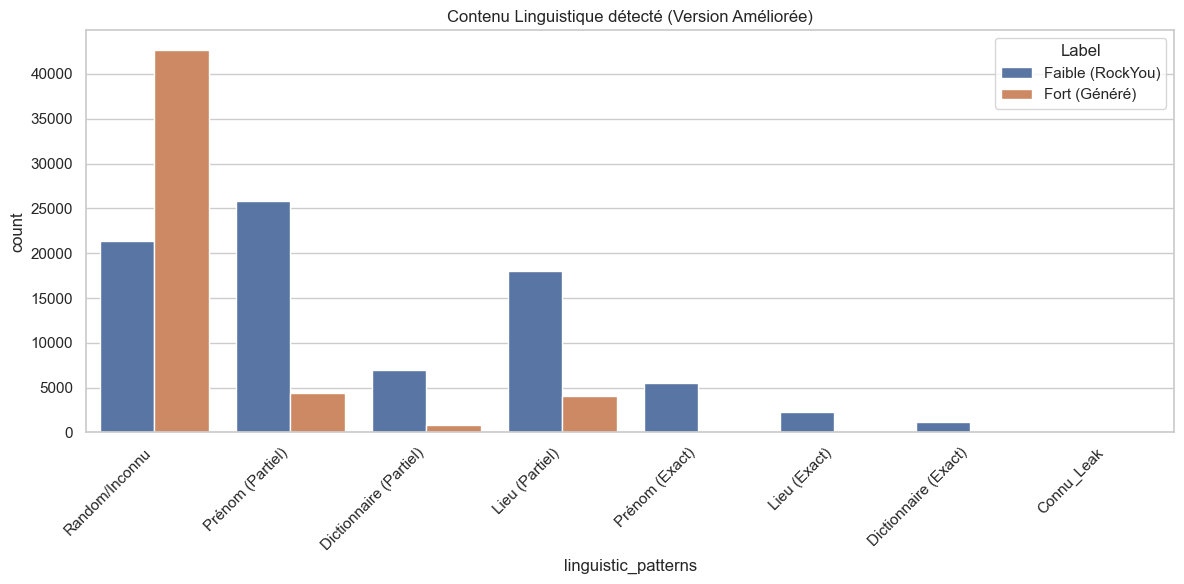

In [26]:
def check_linguistic_content(pwd):
    """
    Vérifie si le mot de passe contient des tokens connus (même partiels).
    Version améliorée : cherche des sous-chaînes de caractères.
    """
    # 1. Nettoyage strict (lettres minuscules uniquement)
    clean_pwd = re.sub(r'[^a-zA-Z]', '', str(pwd)).lower()
    
    found_types = set() # On utilise un set pour éviter les doublons
    
    # 2. Vérification brute : est-ce que le mot de passe entier est dans la liste RockYou/Weak ?
    # (On le fait avant le nettoyage pour attraper "password123" tel quel)
    if str(pwd).lower() in weak_set: 
        found_types.add('Connu_Leak')

    # 3. Vérification des sous-chaînes (Algorithme rapide)
    # On regarde tous les morceaux de mots de 4 lettres ou plus
    n = len(clean_pwd)
    min_len = 4 
    
    if n >= min_len:
        # Si le mot complet est directement dans le dico (Ex: "abricot")
        if clean_pwd in words_set: found_types.add('Dictionnaire (Exact)')
        if clean_pwd in names_set: found_types.add('Prénom (Exact)')
        if clean_pwd in places_set: found_types.add('Lieu (Exact)')
        
        # Recherche de morceaux (Substrings)
        for i in range(n):
            for j in range(i + min_len, n + 1):
                sub = clean_pwd[i:j]
                if sub in words_set: found_types.add('Dictionnaire (Partiel)')
                if sub in names_set: found_types.add('Prénom (Partiel)')
                if sub in places_set: found_types.add('Lieu (Partiel)')

    # Conversion en liste pour l'affichage/pandas
    return list(found_types) if found_types else ["Random/Inconnu"]

print("Nouvelle analyse linguistique (plus fine) en cours...")
# Note : Si tu n'as pas tqdm d'installé, utilise .apply() au lieu de .progress_apply()
df['linguistic_patterns'] = df['password'].apply(check_linguistic_content)

# --- Résumé Chiffré ---
print("Top 10 des patterns détectés :")
print(df['linguistic_patterns'].value_counts().head(10))

# --- Visualisation ---
df_exploded = df.explode('linguistic_patterns')
plt.figure(figsize=(12, 6))
sns.countplot(x='linguistic_patterns', data=df_exploded, hue='label')

plt.title("Contenu Linguistique détecté (Version Améliorée)")
plt.xticks(rotation=45, ha='right') # Rotation pour mieux lire les étiquettes
plt.legend(title='Label', labels=['Faible (RockYou)', 'Fort (Généré)'])
plt.tight_layout()
plt.show()

Recherche de patterns en cours...


,has_date,has_repeat,has_sequence
label,,,
0,6.635062,2.900464,2.066331
1,0.000000,0.204000,0.030000


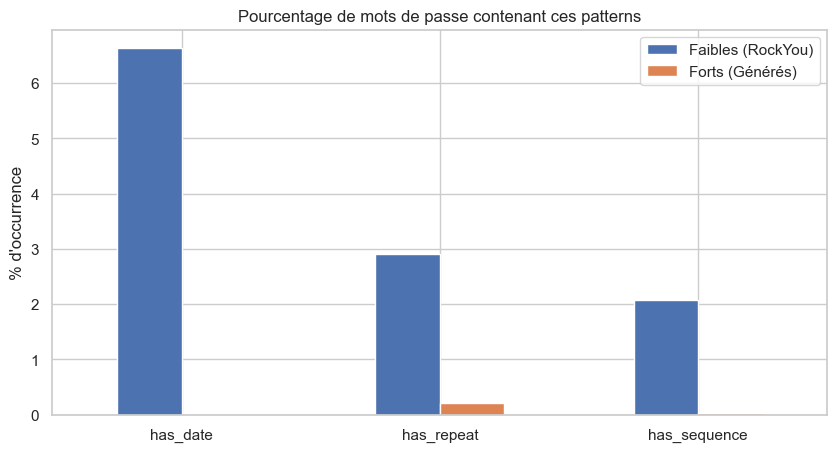

In [27]:
def analyze_patterns(pwd):
    pwd = str(pwd)
    stats = {
        # Cherche 19xx ou 20xx
        'has_date': bool(re.search(r'(19|20)\d{2}', pwd)), 
        # Cherche un caractère répété 3 fois (aaa, 111)
        'has_repeat': bool(re.search(r'(.)\1{2,}', pwd)),   
        # Cherche des séquences évidentes
        'has_sequence': bool(re.search(r'123|abc|qwerty|azerty', pwd.lower())) 
    }
    return pd.Series(stats)

print("Recherche de patterns en cours...")
patterns_df = df['password'].apply(analyze_patterns)
# On colle les résultats au dataframe principal
df = pd.concat([df, patterns_df], axis=1)

# Calcul des pourcentages par Label
summary = df.groupby('label')[['has_date', 'has_repeat', 'has_sequence']].mean() * 100
display(summary)

# Visualisation graphique
summary.T.plot(kind='bar', figsize=(10, 5))
plt.title("Pourcentage de mots de passe contenant ces patterns")
plt.ylabel("% d'occurrence")
plt.xticks(rotation=0)
plt.legend(["Faibles (RockYou)", "Forts (Générés)"])
plt.show()

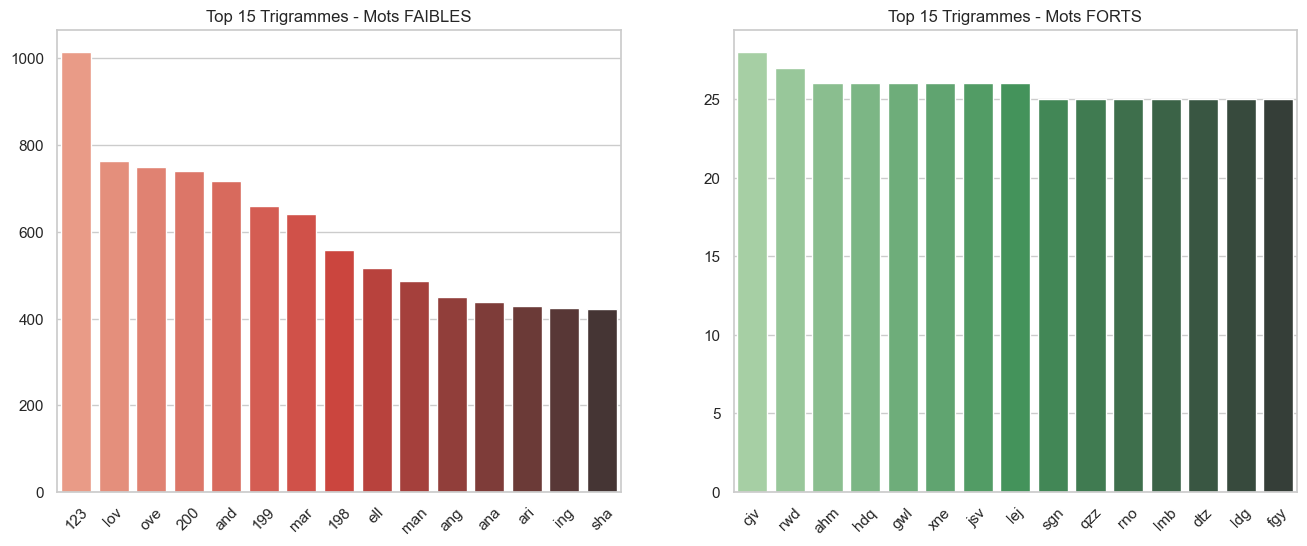

In [28]:
def get_ngrams(text_series, n=3, top_k=15):
    all_ngrams = []
    for pwd in text_series:
        pwd = str(pwd).lower()
        if len(pwd) < n: continue
        ngrams = [pwd[i:i+n] for i in range(len(pwd)-n+1)]
        all_ngrams.extend(ngrams)
    return Counter(all_ngrams).most_common(top_k)

# Analyse séparée
weak_trigrams = get_ngrams(df[df['label']==0]['password'], n=3)
strong_trigrams = get_ngrams(df[df['label']==1]['password'], n=3)

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- CORRECTION ICI ---
# On ajoute hue=list(x1) et legend=False
x1, y1 = zip(*weak_trigrams)
sns.barplot(x=list(x1), y=list(y1), hue=list(x1), legend=False, ax=axes[0], palette="Reds_d")
axes[0].set_title("Top 15 Trigrammes - Mots FAIBLES")
axes[0].tick_params(axis='x', rotation=45)

# --- ET ICI ---
x2, y2 = zip(*strong_trigrams)
sns.barplot(x=list(x2), y=list(y2), hue=list(x2), legend=False, ax=axes[1], palette="Greens_d")
axes[1].set_title("Top 15 Trigrammes - Mots FORTS")
axes[1].tick_params(axis='x', rotation=45)

plt.show()

Nombre d'anomalies détectées (RockYou mais haute entropie) : 2341

--- Exemples de 'Faux Forts' (Complexité mathématique mais structure humaine) ---


,password,entropy,linguistic_patterns,has_date
44,Maybelle.Qiolevvu,1.000000,"[Lieu (Partiel), Prénom (Partiel)]",False
68,brandonalejandro,0.752070,"[Lieu (Partiel), Prénom (Partiel), Dictionnair...",False
76,scabster=3:19,0.791370,"[Lieu (Partiel), Prénom (Partiel), Dictionnair...",False
167,123456789_tt,0.730496,[Random/Inconnu],False
191,*soyelgeorge*25,0.913119,"[Lieu (Partiel), Prénom (Partiel)]",False
204,Mi$un'sbrthd8iz12256,1.000000,[Random/Inconnu],False
217,*tequieromucho*,0.878697,"[Lieu (Partiel), Prénom (Partiel)]",False
235,duncan_813_12,0.791370,"[Prénom (Partiel), Lieu (Partiel), Lieu (Exact...",False
237,RI.majol.38,0.721005,"[Lieu (Partiel), Prénom (Partiel)]",False
287,simpleman@51,0.730496,"[Lieu (Partiel), Prénom (Partiel)]",False


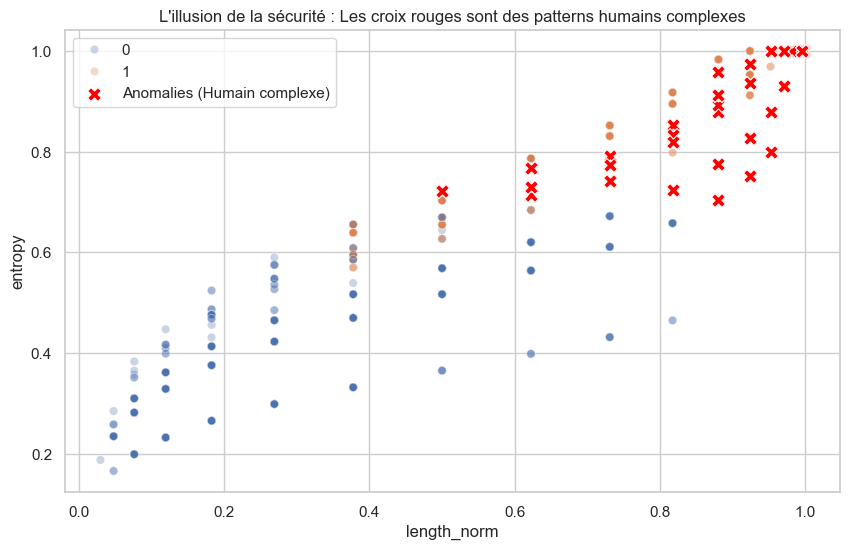

In [29]:
# On cherche : 
# 1. Label = 0 (Issu de RockYou, donc compromis)
# 2. Entropie > 0.70 (Donc mathématiquement solide, souvent > 70 bits selon ta normalisation)

# Adapte le seuil 0.70 selon tes valeurs d'entropie dans ton CSV
anomalies = df[ (df['label'] == 0) & (df['entropy'] > 0.70) ].copy()

print(f"Nombre d'anomalies détectées (RockYou mais haute entropie) : {len(anomalies)}")

if len(anomalies) > 0:
    print("\n--- Exemples de 'Faux Forts' (Complexité mathématique mais structure humaine) ---")
    # On affiche le mot de passe et ce qu'on a détecté dedans
    cols_to_show = ['password', 'entropy', 'linguistic_patterns', 'has_date']
    display(anomalies[cols_to_show].head(15))
    
    # Graphique : Nuage de points
    plt.figure(figsize=(10, 6))
    # On prend un échantillon aléatoire global pour le fond
    sample = df.sample(min(2000, len(df)))
    sns.scatterplot(data=sample, x='length_norm', y='entropy', hue='label', alpha=0.3)
    
    # On superpose les anomalies en Rouge bien visible
    sns.scatterplot(data=anomalies.head(100), x='length_norm', y='entropy', 
                    color='red', marker='X', s=100, label='Anomalies (Humain complexe)')
    
    plt.title("L'illusion de la sécurité : Les croix rouges sont des patterns humains complexes")
    plt.show()
else:
    print("Aucune anomalie trouvée avec ce seuil d'entropie. Essaie de baisser le seuil (ex: > 0.6)")